In [1]:
!pip install gym[classic_control]
!pip install tqdm
!pip install gym[box2d]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt 
import random
import math
import time

/home/rahul/.local/lib/python3.6/site-packages/gym/core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [3]:
env_name = "Acrobot-v1"
render_Mode = "human"
# env = gym.make(env_name)

In [4]:
def getAngle(cos_val, sin_val):   
    a_acos = math.acos(cos_val)
    angle = 0
    if sin_val < 0:
        angle = math.degrees(-a_acos) % 360
    else: 
        angle = math.degrees(a_acos)
    return angle

In [5]:
def transformObs(obs):
    ang1 = int(getAngle(obs[0], obs[1])/10)
    ang2 = int(getAngle(obs[2], obs[3])/10)
    new_obs = []
    new_obs.append(ang1)
    new_obs.append(ang2)
    new_obs.append(int((obs[4] + 12.57)/2))
    new_obs.append(int((obs[5] + 28.28)/2))
    return new_obs

In [6]:
pi = [[[[0 for _ in range(29)] for _ in range(13)] for _ in range(36)] for _ in range(36)]

In [7]:
val_func = [[[[0 for _ in range(29)] for _ in range(13)] for _ in range(36)] for _ in range(36)]

In [8]:
next_state = [[[[[(-1, -1, -1, -1) for _ in range(3)] for _ in range(29)] for _ in range(13)] for _ in range(36)] for _ in range(36)]

In [9]:
occur_count = [[[[0 for _ in range(29)] for _ in range(13)] for _ in range(36)] for _ in range(36)]

In [10]:
tot = [[[[0 for _ in range(29)] for _ in range(13)] for _ in range(36)] for _ in range(36)]

In [11]:
gamma = 0.8

In [12]:
def performEpisode():
    Acrobot = gym.make(env_name)
    #Acrobot = gym.make(env_name, render_mode=render_Mode)
    pre_obs = Acrobot.reset()
    pre_obs = transformObs(pre_obs)
    done = False
    SR_list = []
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        SR_list.append((a, b, c, d))
        act = random.randint(0, 2) 
        pre_obs, reward, done, info = Acrobot.step(act)
        SR_list.append(reward)
        pre_obs = transformObs(pre_obs)
        a_n, b_n, c_n, d_n = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        next_state[a][b][c][d][act] = (a_n, b_n, c_n, d_n)
        
    G = 0    
    for i in range(len(SR_list)-1, 0, -2):
        G = gamma*G + SR_list[i]
        a, b, c, d = SR_list[i-1]
        tot[a][b][c][d] += G
        occur_count[a][b][c][d] += 1
        val_func[a][b][c][d] = tot[a][b][c][d]/occur_count[a][b][c][d]
    Acrobot.close()

In [13]:
def getReward():
    Acrobot = gym.make(env_name)
    pre_obs = Acrobot.reset() 
    pre_obs = transformObs(pre_obs)
    done = False
    tot_reward = 0
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        
        req_act = random.randint(0, 2)   
        max_val = -200000000000
        for act in range(0, 3):
            a_n, b_n, c_n, d_n = next_state[a][b][c][d][act]
            if a_n!=-1 and b_n!=-1 and c_n!=-1 and d_n!=-1:
                if val_func[a_n][b_n][c_n][d_n] >= max_val:
                    max_val = val_func[a_n][b_n][c_n][d_n]
                    req_act = act 
 
        pre_obs, reward, done, info = Acrobot.step(req_act)
        tot_reward += reward
        pre_obs = transformObs(pre_obs)   
    Acrobot.close() 
    return tot_reward

In [14]:
def get_policy():
    for i in range(36):
        for j in range(36):
            for v1 in range(13):
                for v2 in range(29):
                    max_val = -200000000000
                    req_act = -1
                    for act in range(0, 3):
                        a, b, c, d = next_state[i][j][v1][v2][act]
                        if a!=-1 and b!=-1 and c!=-1 and d!=-1:
                            if val_func[a][b][c][d] >= max_val:
                                max_val = val_func[a][b][c][d]
                                req_act = act
                    if req_act != -1:
                        pi[i][j][v1][v2] = req_act 

In [15]:
x_rew = []
avg_reww = []
orig_reww = []
for cnt in tqdm (range (400000), desc="Loading…", ascii=False, ncols=100):
    performEpisode()
    if cnt>0 and cnt%4000 == 0:
        rew = 0
        orig_reww.append(getReward())
        for _ in range(200):
            rew += getReward()
        avg_reww.append(rew/200)    
        x_rew.append(cnt/4000)

Loading…:   0%|                                                          | 0/400000 [00:00<?, ?it/s]/home/rahul/.local/lib/python3.6/site-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/rahul/.local/lib/python3.6/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=

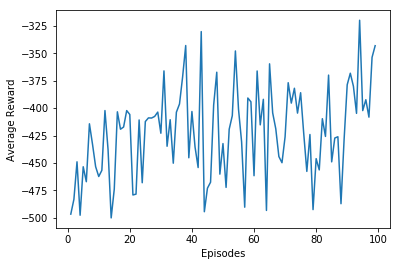

In [16]:
plt.plot(x_rew, avg_reww)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.show()

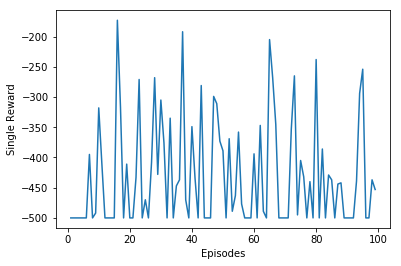

In [17]:
plt.plot(x_rew, orig_reww)
plt.xlabel("Episodes")
plt.ylabel("Single Reward")
plt.show()

In [18]:
get_policy()

In [19]:
Acrobot = gym.make(env_name)
# Acrobot = gym.make(env_name, render_mode=render_Mode)
pre_obs = Acrobot.reset() 
pre_obs = transformObs(pre_obs)
done = False
reward = 0
while not done:
    a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
    act = pi[a][b][c][d]
    pre_obs, rew, done, info = Acrobot.step(act)
    pre_obs = transformObs(pre_obs)
    reward += rew
Acrobot.close()    
print(reward)

-500.0


In [20]:
reward = 0
min_iter = 500
rew_list = []
for _ in tqdm (range (1000), desc="Loading…", ascii=False, ncols=100):
    Acrobot = gym.make(env_name)
    #Acrobot = gym.make(env_name, render_mode=render_Mode)
    pre_obs = Acrobot.reset() 
    pre_obs = transformObs(pre_obs)
    done = False
    cur = 0
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        act = pi[a][b][c][d]
        pre_obs, rew, done, info = Acrobot.step(act)
        pre_obs = transformObs(pre_obs)
        cur += rew
    reward += cur    
    min_iter = min(min_iter, -cur)
    rew_list.append(cur)
    Acrobot.close()
rew_list.sort(reverse=True)   
print("Average reward:", reward/1000) 
print("Highest Reward:", -min_iter)
print(rew_list[:50])

Loading…: 100%|█████████████████████████████████████████████████| 1000/1000 [01:17<00:00, 12.84it/s]

Average reward: -461.508
Highest Reward: -217.0
[-217.0, -220.0, -225.0, -243.0, -245.0, -245.0, -251.0, -252.0, -254.0, -255.0, -258.0, -259.0, -260.0, -277.0, -278.0, -282.0, -286.0, -289.0, -291.0, -291.0, -291.0, -297.0, -298.0, -298.0, -301.0, -302.0, -302.0, -303.0, -304.0, -306.0, -306.0, -307.0, -311.0, -313.0, -314.0, -315.0, -321.0, -322.0, -323.0, -323.0, -324.0, -325.0, -327.0, -327.0, -330.0, -330.0, -330.0, -331.0, -331.0, -332.0]
